# Quickstart Tutorial

This notebooks illustrates the most typical usage of `wakeflow`, where the user wants to find the perturbations induced by some known/hypothesised planet in a disk. In this case, we will model the hypothesised wake induced in the disk of HD 163296 by the embedded protoplanet (see [Pinte et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...860L..13P/abstract), [Calcino et al. 2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...929L..25C/abstract)).

## Model Setup and Configuration

To get started, we import the class `WakeflowModel` from `wakeflow`:

In [1]:
from wakeflow import WakeflowModel

If you have `pymcfost` installed, then some warnings about mpl_scatter_density and progress bar may appear. You can safely ignore them.

Next, we instantiate a `WakeflowModel` object and assign it to some variable, that we will call `hd163_model`:

In [2]:
hd163_model = WakeflowModel()

Model initialised.


Now, we wish to choose our model parameters. In all of the Wakeflow documentation this is referred to as "configuring" the model. For our model we want:
\begin{align*}
M_\mathrm{star} &= 1.9 \, \mathrm{M_\odot} \\
M_\mathrm{planet} &= 0.5 \, \mathrm{M_{Jupiter}} \\
R_\mathrm{outer} &= 500 \, \mathrm{AU} \\
R_\mathrm{planet} &= 256 \, \mathrm{AU} \\
R_\mathrm{ref} &= 256 \, \mathrm{AU} \\
q &= 0.35 \\
p &= 2.15 \\
\frac{H}{R}(R_\mathrm{ref}) &= 0.09 \\
\mathrm{cw_{rotation}} &= \mathrm{False} \\
\mathrm{grid \, type} &= \mathrm{cartesian} \\
n_x &= 600 \\
n_y &= 600 \\
n_z &= 30.
\end{align*}

These models specify the system, disk and planet parameters, as well as the grid geometry. $M_\mathrm{star}$ is the central star mass, $M_\mathrm{planet}$ is the mass of the perturbing planet, $R_\mathrm{outer}$ is the outermost disk radius where `wakeflow` will model the system to, $R_\mathrm{planet}$ is the planet orbital radius. The other disk quantites are defined in the following way, satisfying vertical hydrostatic equilibrium in the gas disk

\begin{align*}
\rho(R,z) &= \rho(R_\mathrm{ref}) \left( \frac{R}{R_\mathrm{ref}} \right)^{-p} \exp{\left( \frac{G M_\mathrm{star}}{c_s^2} \left[ \frac{1}{\sqrt{R^2 - z^2}} - \frac{1}{R}  \right]\right)} \\
c_s(R,z) &= c_s(R_\mathrm{ref}) \left( \frac{R}{R_\mathrm{ref}} \right)^{-q} \\
\frac{H}{R}(R,z) &= \frac{c_s}{R \Omega_\mathrm{K}} = \frac{H}{R} (R_\mathrm{ref}) \left( \frac{R}{R_\mathrm{ref}} \right)^{0.5-q},
\end{align*}

where $\rho$ is density, $c_s$ is the sound speed and $\Omega_K$ is Keplerian rotation. $\rho(R_\mathrm{ref})$ in `wakeflow` is set by default to $1$, while $c_s(R_\mathrm{ref})$ is fixed by your choice of $\frac{H}{R} (R_\mathrm{ref})$. In our case we have defined all of our quantites at the planet radius $R=R_\mathrm{planet}$ and so $R_\mathrm{ref}=R_\mathrm{planet}$. 

We have also specified $\mathrm{cw_{rotation}} = \mathrm{False}$, ie. we want our disk to rotate anticlockwise. Finally, we have chosen to get our results on a Cartesian grid with 600 points in the $x$-direction, 600 points in the $y$-direction and 30 points in the $z$-direction. For all other possible `wakeflow` parameters we will use the defaults. A full list of every `wakeflow` parameter, an explanation of said parameter, and its default value is available under the _Reference_ section in the documentation.

To actually give these parameters to `wakeflow`, we use the `configure` method on our `WakeflowModel` object:

In [3]:
import numpy as np

hd163_model.configure(
    name        = "quickstart_tutorial",
    system      = "HD_163296",
    m_star      = 1.9,
    m_planet    = 0.5,
    r_outer     = 500,
    r_planet    = 256,
    r_ref       = 256,
    q           = 0.35,
    p           = 2.15,
    hr          = 0.09,
    cw_rotation = False,
    grid_type   = "cartesian",
    n_x         = 600,
    n_y         = 600,
    n_z         = 30
)

Model configured.


Note that we have specified two previously unmentioned parameters, `name` and `system`. These dictate where your results will be saved relative to the current directory. `system` will be the parent directory and `name` will be where the results from this model are stored: `working_dir/system/name/your_results_here`. You may also give `configure` a list of values for `m_planet` instead of a single value to generate models with multiple planet masses but the same disk parameters. In this case the results of these are saved in separate folders inside the `name` directory. Any `wakeflow` parameters that you do not specify in the `configure` arguments is left as default.

NOTE: It is important to consider the limitations of the semi-analytical framework used by `wakeflow` when choosing the planet mass. It fundamentally assumes that the problem can be split into separate linear and non-linear regimes near and far from the planet. This relies on the planet being sufficiently small such that the wake does not shock immediately upon formation. The condition for this is that $M_\mathrm{planet} < M_\mathrm{thermal}$, where $M_\mathrm{thermal}$ is the gap-opening mass defined as $M_\mathrm{thermal} = \frac{2}{3} (\frac{H}{R_{\rm planet}})^3 M_{\rm star}$. It is not obvious how meaningful results are when this condition is violated. See [Goodman & Rafikov (2001)](https://ui.adsabs.harvard.edu/abs/2001ApJ...552..793G/abstract) and [Rafikov (2002)](https://ui.adsabs.harvard.edu/abs/2002ApJ...569..997R/abstract) for more details. `wakeflow` will automatically calculate $M_{\rm thermal}$ and warn you if the condition is violated.

## Running the Model

Now, we simply run the model using the `run` method.

`wakeflow` will first check that the combination of parameters given is sensical. If there is an issue it will either abort or provide a warning to the user depending on the severity.

                 __        ______             
 _      ______ _/ /_____  / __/ /___ _      __
| | /| / / __ `/ //_/ _ \/ /_/ / __ \ | /| / /
| |/ |/ / /_/ / ,< /  __/ __/ / /_/ / |/ |/ / 
|__/|__/\__,_/_/|_|\___/_/ /_/\____/|__/|__/  

* Performing checks on model parameters:
M_thermal = 0.967 M_Jup
M_planet  = 0.517 M_th
Parameters Ok - continuing
Overwriting previous results

* Creating 0.5 Mj model:
Generating unperturbed background disk
Extracting linear perturbations nearby planet
Propagating outer wake... 
Completed in 1.30 s
Propagating inner wake... 
Completed in 1.35 s
Mapping to Physical Coords
Completed in 1.54 s

* Displaying results:


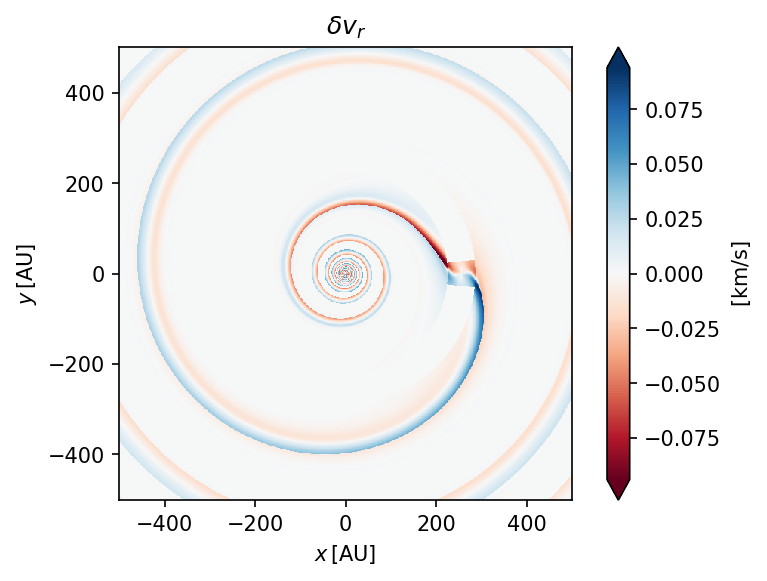

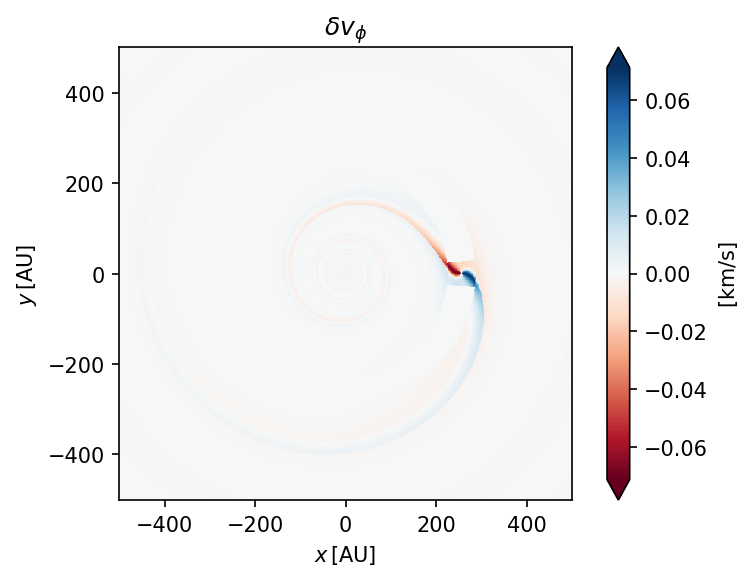

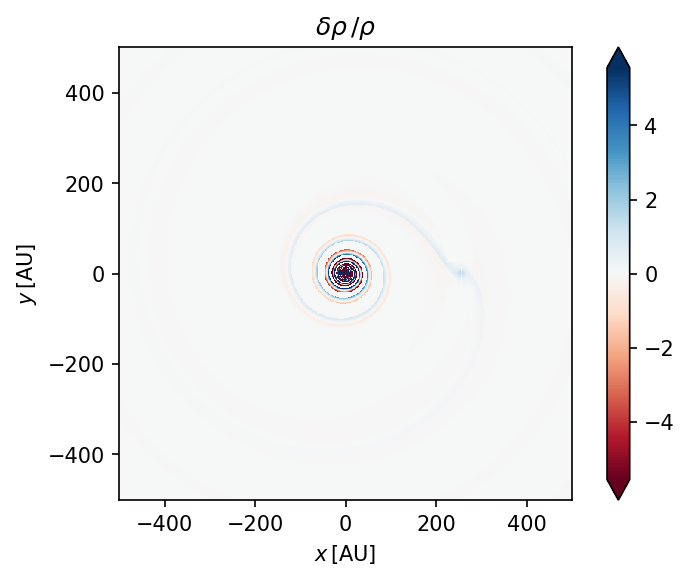


* Saving results:
Perturbations saved to HD_163296/quickstart_tutorial/0.5Mj
Total         saved to HD_163296/quickstart_tutorial/0.5Mj

* Done!


In [4]:
hd163_model.run(overwrite=True)

Success! We have successfully created our first model, and we can see plots of the generated perturbations above! `wakeflow` has also provided us with a message about where our results have been saved.

NOTE: We also provided the option argument `overwrite=True` so that if results already exist for the `system` and `name` given, they will be overwritten. `overwrite=False` by default so unless specified to `True`, the `run` method will return an exception if results already exist.

## Results Format

Lets check that our results are really there:

In [5]:
!ls HD_163296/quickstart_tutorial

0.5Mj                           quickstart_tutorial_config.yaml


We can see that there is a directory called `0.5Mj`, and a `.yaml` file in the results directory. Lets check that the former contains our model results:

In [6]:
!ls HD_163296/quickstart_tutorial/0.5Mj

X.npy           delta_rho.npy   rho_z0.pdf      total_v_r.npy
Y.npy           delta_v_phi.npy total_rho.npy   vphi_z0.pdf
Z.npy           delta_v_r.npy   total_v_phi.npy vr_z0.pdf


And indeed it does! The results are stored as .npy files so that they aren't very large. The `X.npy`, `Y.npy` and `Z.npy` files are the 3D grid of the results, specifying the x, y and z points on the grid respectively. The `delta_rho.npy`, `delta_v_r.npy` and `delta_v_phi.npy` files are the density, radial velocity and azimuthal velocity perturbations respectively. The `total_rho.npy`, `total_v_r.npy` and `total_v_phi.npy` are the total values of the same quantites, ie. the unperturbed background disk plus the perturbations.

Note that each of the `.npy` files contain a single, 3D `numpy` array. This array has dimensions ($n_x$, $n_z$, $n_y$) for Cartesian grid geometry, and dimensions ($n_\phi$, $n_z$, $n_r$) for Cylindrical grid geometry.

The `.pdf` files are the same plots that the `run` method showed upon completion, which are the perturbations in the disk mid-plane at $z=0$.

Finally, we note that `wakeflow` also generated a `.yaml` file in the results directory:

In [7]:
!cat HD_163296/quickstart_tutorial/quickstart_tutorial_config.yaml

CFL: 0.5
PA: 45
PAp: 45
adiabatic_index: 1.6666667
box_warp: true
cw_rotation: false
damping_malpha: 0.0
dens_ref: 1.0
dimensionless: false
distance: 101.5
grid_type: cartesian
hr: 0.09
inclination: -225
include_linear: true
include_planet: true
m_planet: 0.5
m_star: 1.9
make_midplane_plots: true
n_phi: 160
n_r: 200
n_v: 40
n_x: 600
n_y: 600
n_z: 30
name: quickstart_tutorial
p: 2.15
phi_planet: 0
q: 0.35
r_c: 0
r_inner: 100
r_log: false
r_outer: 500
r_planet: 256
r_ref: 256
run_mcfost: false
save_perturbations: true
save_total: true
scale_box_ang_b: 1.0
scale_box_ang_t: 1.0
scale_box_l: 1.0
scale_box_r: 1.0
show_midplane_plots: true
show_teta_debug_plots: false
system: HD_163296
temp_star: 9250
tf_fac: 1.0
use_box_IC: false
use_old_vel: false
v_max: 3.2
write_FITS: false
z_max: 3


This `.yaml` file contains ALL of the parameters used in our model, including those we did not specify and were left as default values. It is provided so that you can easily reproduce your results in the event that you lose your run script. It is also possible for `wakeflow` to be configured straight from such `.yaml` files instead of using the `configure` method. This is outlined in the _Advanced Configuration_ tutorial.

## Reading Results and Visualisation

Reading and plotting the results from a wakeflow model is as simple as reading the `.npy` files using `numpy`, and then understanding the grid dimensions so that you can plot what you want. As an example, we show here reading and plotting the total density at multiple heights in the disk.

Firstly, we will need `numpy` and `matplotlib.pyplot` so lets import those:

In [8]:
import numpy                as np
import matplotlib.pyplot    as plt

Now we can read in the $x$, $y$ and $z$ points:

In [9]:
# 0.5 Mj planet results directory
results = "HD_163296/quickstart_tutorial/0.5Mj"

# load arrays
X = np.load(f"{results}/X.npy")
Y = np.load(f"{results}/Y.npy")
Z = np.load(f"{results}/Z.npy")

And we can read in the total density and velocities

In [10]:
rho     = np.load(f"{results}/total_rho.npy")
v_r     = np.load(f"{results}/total_v_r.npy")
v_phi   = np.load(f"{results}/total_v_phi.npy")

Lets check that the shape of our arrays is what we expect. Remember, they should be ($n_x$, $n_z$, $n_y$), which for us is (600, 30, 600).

In [11]:
print(X.shape, Y.shape, Z.shape)
print(rho.shape)
print(v_r.shape)
print(v_phi.shape)

(600, 30, 600) (600, 30, 600) (600, 30, 600)
(600, 30, 600)
(600, 30, 600)
(600, 30, 600)


We can extract the x, y and z values of the grid into 1D arrays by slicing appropriately:

In [12]:
x = X[:,0,0]
y = Y[0,0,:]
z = Z[0,:,0]

# check we get what we expect for minimum and maximum values
print(f"x_min = {x.min()}, x_max = {x.max()}")
print(f"y_min = {y.min()}, y_max = {y.max()}")
print(f"z_min = {z.min()}, z_max = {z.max()}")

x_min = -500.0, x_max = 500.0
y_min = -500.0, y_max = 500.0
z_min = 0.0, z_max = 149.2599440016262


Note that the maximum $z$ value is chosen by `wakeflow` to be the scale height $H=c_s/\Omega_\mathrm{K}$ at $R_\mathrm{outer}$.

We can now plot the total density, for instance at the mid-plane where $z=0$:

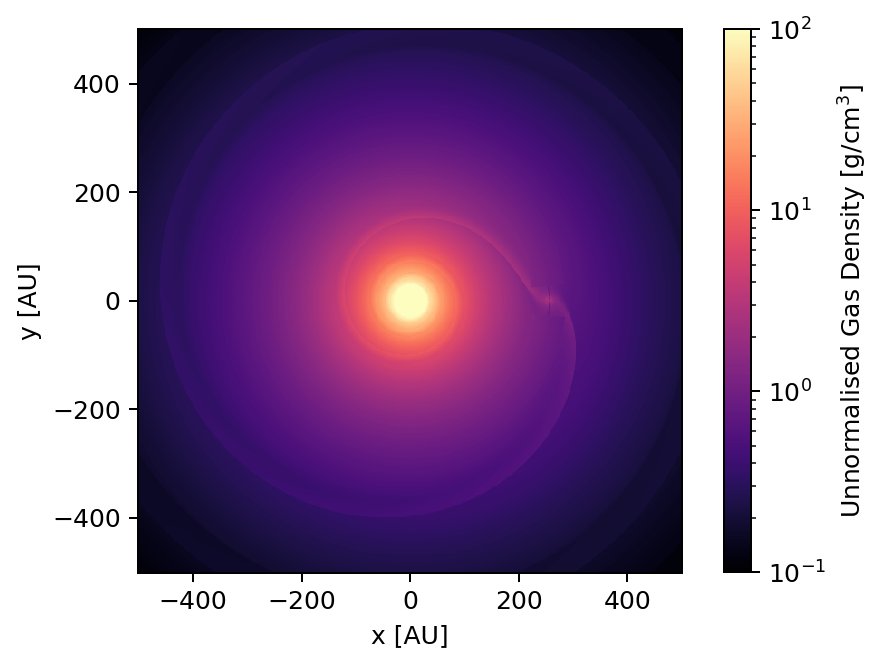

In [13]:
import matplotlib.colors as colors

fig, ax = plt.subplots(dpi=180)
c = ax.pcolormesh(X[:,0,:], Y[:,0,:], rho[:,0,:], shading="nearest", norm=colors.LogNorm(0.1, 100), cmap="magma")
ax.axis("scaled")
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")
plt.colorbar(c, label=r"Unnormalised Gas Density [$\mathrm{g/cm^3}$]")
plt.show()

As well as the velocities in the mid-plane:

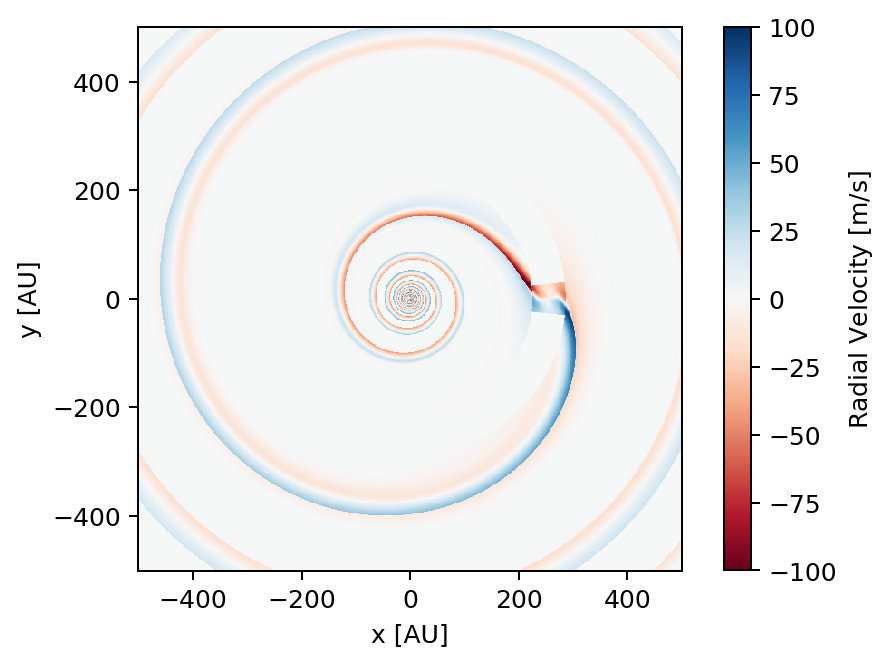

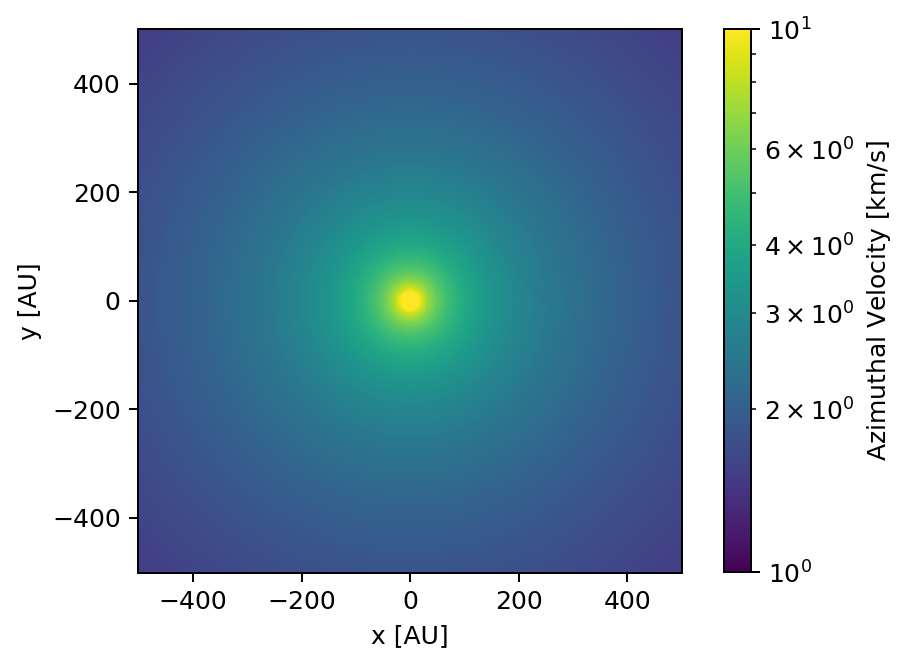

In [14]:
fig, ax = plt.subplots(dpi=180)
c = ax.pcolormesh(X[:,0,:], Y[:,0,:], v_r[:,0,:]*1e3, shading="nearest", vmin=-100, vmax=100, cmap="RdBu")
ax.axis("scaled")
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")
plt.colorbar(c, label=r"Radial Velocity [$\mathrm{m/s}$]")
plt.show()

fig, ax = plt.subplots(dpi=180)
c = ax.pcolormesh(X[:,0,:], Y[:,0,:], v_phi[:,0,:], shading="nearest", norm=colors.LogNorm(1, 10), cmap="viridis")
ax.axis("scaled")
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")
plt.colorbar(c, label=r"Azimuthal Velocity [$\mathrm{km/s}$]")
plt.show()

Since all the radial motions in the disk are induced by the planet, the planet wake is easy to see in the top figure. On the other hand, the deviations in azimuthal velocity are small when compared with the unperturbed background rotation of the disk, and so the wake is faint in the bottom figure. If you wish to look at just the deviations induced in `v_phi`, you can instead read and plot `delta_v_phi.npy`.

It is also important to note that the semi-analytic framework, and indeed `wakeflow` is 2D, and so it only calculates the density perturbations $\delta \rho / \rho$ and the velocity perturbations $\delta v_r$, $\delta v_\phi$ in the mid-plane of the disk where $z=0$. For the results above the mid-plane where $z\ne0$, the perturbations are simply copies of that in the mid-plane.

Let's now plot the total density at $z=10 \, \mathrm{AU}$. First we need to find the index to slice the array where $z$ is closest to $10$:

In [15]:
ind_10au = np.argmin(z < 10)
print(ind_10au)

2


And now plotting:

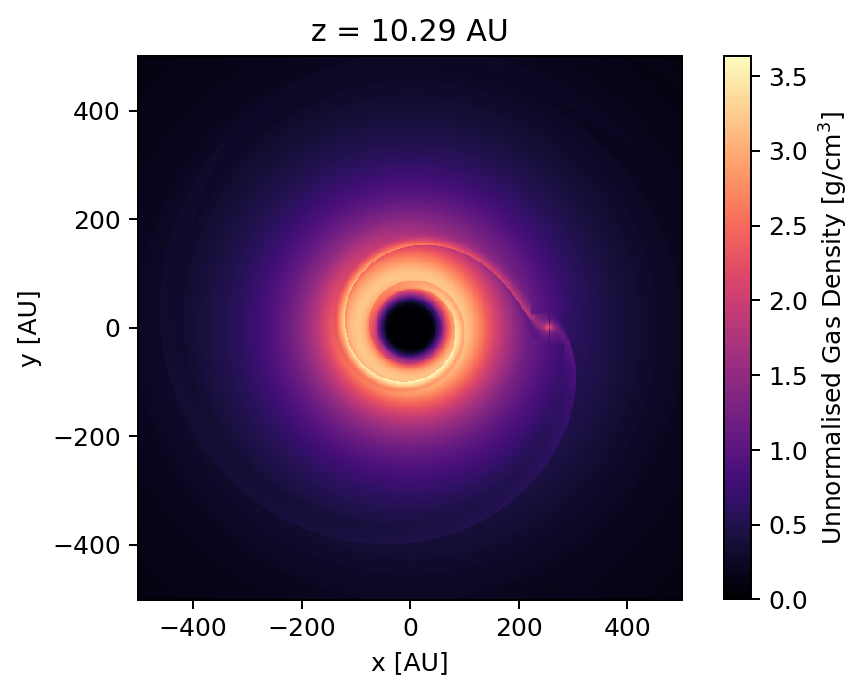

In [16]:
fig, ax = plt.subplots(dpi=180)
c = ax.pcolormesh(X[:,ind_10au,:], Y[:,ind_10au,:], rho[:,ind_10au,:], shading="nearest", cmap="magma")
ax.axis("scaled")
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")
ax.set_title(f"z = {round(z[ind_10au], 2)} AU")
plt.colorbar(c, label=r"Unnormalised Gas Density [$\mathrm{g/cm^3}$]")
plt.show()

We see that the total density in the centre of the disk is much lower than the mid-plane. However note that the perturbations $\delta \rho / \rho$ are still _exactly_ the same as in the mid-plane, as already mentioned.

This concludes the current tutorial. 

The _Advanced Configuration_ tutorial covers how to configure `wakeflow` models using `.yaml` files and dictionaries, and how to use this to easily perform parameter space scans. The tutorial also covers how to change advanced/developer parameters.

The _Using Wakeflow with MCFOST_ tutorial covers how to generate models that can be fed into the radiative transfer code `MCFOST` in order to generate synthetic observations.

Under the _Reference_ sections of the documentation, the _Wakeflow Parameters_ section provides a detailed explanation of ALL `wakeflow` parameters, and the _Disk Structure_ section provides an explanation of the unperturbed disk model used by `wakeflow` including how to use an exponentially tapered density profile.